In [10]:
!git clone https://github.com/ianlw/deep-alzheimer.git

Cloning into 'deep-alzheimer'...
remote: Enumerating objects: 6406, done.
remote: Counting objects: 100% (6406/6406), done.
remote: Compressing objects: 100% (6406/6406), done.
remote: Total 6406 (delta 0), reused 6406 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6406/6406), 32.96 MiB | 16.60 MiB/s, done.


In [2]:
# Forzar uso de memoria eficiente
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verificar política activa
print("Política de precisión:", mixed_precision.global_policy())


Política de precisión: <DTypePolicy "mixed_float16">


In [3]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuración inicial

In [4]:
!pip install tensorflow keras scikit-learn matplotlib numpy pandas opencv-python

**Reasoning**:
Verify that the installations were successful by importing each library.



In [5]:
import tensorflow as tf
import keras
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import cv2 as cv

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv.__version__)

print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Keras version: 3.10.0
Scikit-learn version: 1.6.1
Matplotlib version: 3.10.0
Numpy version: 2.0.2
Pandas version: 2.2.2
OpenCV version: 4.12.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Carga y preprocesamiento de datos


In [11]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Definir la ruta base del dataset
base_dir = 'deep-alzheimer/'

# 2. Crear listas para almacenar las imágenes y sus etiquetas
images = []
labels = []
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
img_size = (128, 128)

# Iterar a través de las carpetas de cada clase
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        # 3. Cargar cada imagen usando OpenCV y redimensionarla
        img = cv.imread(img_path)
        if img is not None:
            img = cv.resize(img, img_size)
            # Mantener en color para flexibilidad con modelos futuros
            images.append(img)
            labels.append(class_name)

# 4. Normalizar los valores de píxeles
images = np.array(images).astype('float32') / 255.0

# 5. Convertir las listas de imágenes y etiquetas a arrays NumPy (ya hecho en el paso anterior para images)
labels = np.array(labels)

# 6. Codificar las etiquetas categóricas a valores numéricos
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 7. Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
# Asegurando la estratificación por etiquetas
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)

print(f"Número total de imágenes cargadas: {len(images)}")
print(f"Dimensiones de las imágenes: {images[0].shape}")
print(f"Número de clases: {len(class_names)}")
print(f"Clases codificadas: {label_encoder.classes_}")
print(f"Tamaño del conjunto de entrenamiento (imágenes): {X_train.shape}")
print(f"Tamaño del conjunto de entrenamiento (etiquetas): {y_train.shape}")
print(f"Tamaño del conjunto de prueba (imágenes): {X_test.shape}")
print(f"Tamaño del conjunto de prueba (etiquetas): {y_test.shape}")

Número total de imágenes cargadas: 6400
Dimensiones de las imágenes: (128, 128, 3)
Número de clases: 4
Clases codificadas: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']
Tamaño del conjunto de entrenamiento (imágenes): (5120, 128, 128, 3)
Tamaño del conjunto de entrenamiento (etiquetas): (5120,)
Tamaño del conjunto de prueba (imágenes): (1280, 128, 128, 3)
Tamaño del conjunto de prueba (etiquetas): (1280,)


## Modelo 1: rnn (lstm)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │    12,599,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,599,812 (48.06 MB)

 Trainable params: 12,599,812 (48.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.4807 - loss: 1.1492 - val_accuracy: 0.5000 - val_loss: 1.0360
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4968 - loss: 1.0396 - val_accuracy: 0.5000 - val_loss: 1.0436
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4978 - loss: 1.0384 - val_accuracy: 0.5000 - val_loss: 1.0361
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5093 - loss: 1.0272 - val_accuracy: 0.5000 - val_loss: 1.0398
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5019 - loss: 1.0303 - val_accuracy: 0.5000 - val_loss: 1.0369
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5097 - loss: 1.0345 - val_accuracy: 0.5000 - val_loss: 1.0359
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4943 - loss: 1.0304 - val_accuracy: 0.5000 - val_loss: 1.0362
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5020 - loss: 1.0381 - val_accu

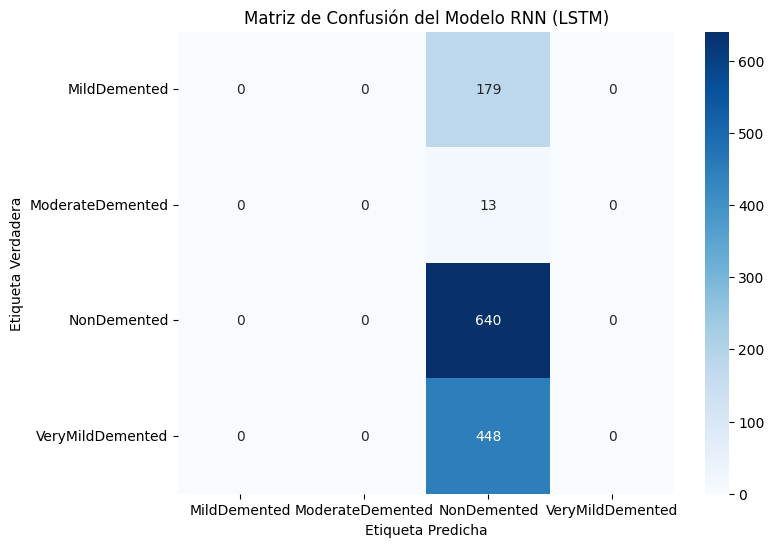

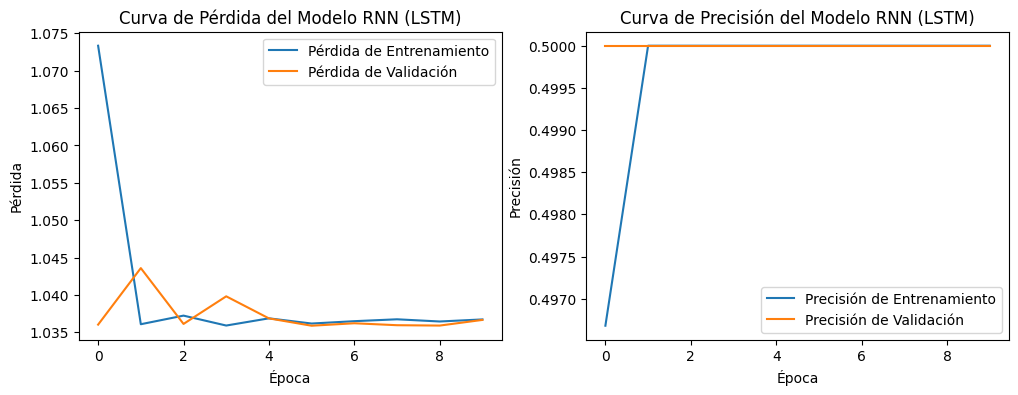

Modelo RNN (LSTM) guardado como 'rnn_alzheimer_classifier.h5'


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Construir el modelo secuencial de Keras con capas LSTM
# Las imágenes tienen forma (alto, ancho, canales). Para una LSTM, necesitamos una entrada secuencial.
# Una forma simple es aplanar cada "fila" o "columna" como un paso de tiempo, o aplanar la imagen completa.
# Aplanaremos la imagen completa en un solo vector para simplificar la entrada secuencial a la LSTM.
# Esto requiere reformar los datos.
# (num_samples, alto, ancho, canales) -> (num_samples, secuencia_longitud, caracteristicas)
# Donde secuencia_longitud podría ser alto * ancho, y caracteristicas podría ser canales.
# O, si aplanamos la imagen completa: (num_samples, 1, alto * ancho * canales)

# Reformar los datos para la LSTM: (num_samples, 1, alto * ancho * canales)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

# Convertir etiquetas a one-hot encoding para la función de pérdida categórica
y_train_one_hot = to_categorical(y_train, num_classes=len(class_names))
y_test_one_hot = to_categorical(y_test, num_classes=len(class_names))

model_rnn = Sequential()
# La capa LSTM espera entrada con forma (num_samples, timesteps, features)
# Nuestro timesteps es 1 después de aplanar, y features es el total de píxeles aplanados.
model_rnn.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) # 64 unidades LSTM
model_rnn.add(Dense(len(class_names), activation='softmax')) # Capa de salida para clasificación

# 3. Compilar el modelo
model_rnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_rnn.summary()

# 4. Entrenar el modelo
# Usaremos X_test y y_test para validación durante el entrenamiento
history_rnn = model_rnn.fit(X_train_lstm, y_train_one_hot,
                            epochs=10, # Número de épocas, ajustar según sea necesario
                            batch_size=32, # Tamaño del lote, ajustar según sea necesario
                            validation_data=(X_test_lstm, y_test_one_hot)) # Usar datos de prueba para validación

# 5. Evaluar el modelo entrenado
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test_lstm, y_test_one_hot, verbose=0)
print(f"Pérdida en el conjunto de prueba: {loss_rnn:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy_rnn:.4f}")

# Calcular F1-score y generar matriz de confusión
y_pred_rnn = model_rnn.predict(X_test_lstm)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)

f1_rnn = f1_score(y_test, y_pred_classes_rnn, average='weighted') # Usar average='weighted' para multiclase
print(f"F1-score en el conjunto de prueba: {f1_rnn:.4f}")

conf_matrix_rnn = confusion_matrix(y_test, y_pred_classes_rnn)

# 6. Generar y visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión del Modelo RNN (LSTM)')
plt.show()

# 7. Trazar las curvas de pérdida y precisión
plt.figure(figsize=(12, 4))

# Curva de Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida de Validación')
plt.title('Curva de Pérdida del Modelo RNN (LSTM)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Curva de Precisión
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión de Validación')
plt.title('Curva de Precisión del Modelo RNN (LSTM)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# 8. Guardar el modelo entrenado
model_rnn.save('rnn_alzheimer_classifier.h5')
print("Modelo RNN (LSTM) guardado como 'rnn_alzheimer_classifier.h5'")

Visualizando algunas predicciones:


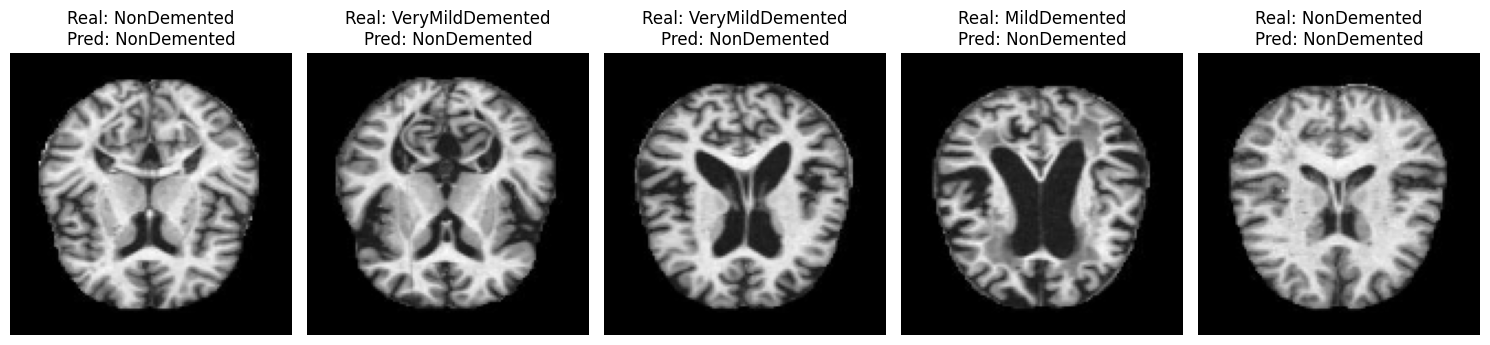

In [13]:
import random
import matplotlib.pyplot as plt

# 9. Visualizar algunas predicciones del modelo en imágenes de prueba
print("Visualizando algunas predicciones:")

# Seleccionar un número aleatorio de imágenes de prueba para visualizar
num_images_to_show = 5
random_indices = random.sample(range(len(X_test)), num_images_to_show)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label_encoded = y_test[idx]
    predicted_label_encoded = y_pred_classes_rnn[idx]

    # Obtener nombres de clase a partir de las etiquetas codificadas
    true_label = label_encoder.inverse_transform([true_label_encoded])[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

    plt.subplot(1, num_images_to_show, i + 1)
    # Mostrar la imagen (revertir la normalización para visualización si es necesario, aunque matplotlib lo maneja bien con floats)
    plt.imshow(img)
    plt.title(f"Real: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Modelo 2: cnn con mecanismo de atención

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Multiply, Permute, Reshape, Activation, Add, Layer
from tensorflow.keras import backend as K
import tensorflow as tf # Import tensorflow to use tf.cast

# 2. Construir el modelo CNN con mecanismo de atención espacial

# Implementar la atención espacial como una capa Keras
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', use_bias=False)

    def call(self, inputs):
        # Asegurarse de que el tipo de datos sea float32 para las operaciones si mixed_float16 está activo
        original_dtype = inputs.dtype
        if original_dtype != tf.float32:
            inputs = tf.cast(inputs, tf.float32)

        # Promedio y máximo pooling a lo largo del eje de canales
        avg_pool = K.mean(inputs, axis=-1, keepdims=True)
        max_pool = K.max(inputs, axis=-1, keepdims=True)
        concat = K.concatenate([avg_pool, max_pool], axis=-1)

        # Aplicar convolución para obtener el mapa de atención
        attention_map = self.conv(concat)

        # Convertir el mapa de atención de nuevo al dtype original si es necesario
        if original_dtype != tf.float32:
             attention_map = tf.cast(attention_map, original_dtype)

        # Aplicar el mapa de atención a las características de entrada
        attended_feature = Multiply()([inputs, attention_map])

        return attended_feature

    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config


# Definir la forma de la entrada
input_shape = (img_size[0], img_size[1], 3)
inputs = Input(shape=input_shape)

# Bloque Convolucional 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

# Bloque Convolucional 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Aplicar mecanismo de atención espacial como una capa
x = SpatialAttention()(x)

# Bloque Convolucional 3 (después de atención)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Aplanar y capas densas
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Añadir Dropout para regularización
outputs = Dense(len(class_names), activation='softmax', dtype='float32')(x) # Capa de salida con activación softmax debe ser float32 para estabilidad numérica

# Crear el modelo
model_cnn_attention = Model(inputs=inputs, outputs=outputs)

# Mostrar resumen del modelo
model_cnn_attention.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 32, 32, 64)     │            98 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,294 (16.36 MB)

 Trainable params: 4,288,294 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Compile the built CNN model with an appropriate optimizer, loss function, and metrics as specified in the instructions.



In [15]:
# 3. Compilar el modelo
model_cnn_attention.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

print("Modelo CNN con atención compilado exitosamente.")

Modelo CNN con atención compilado exitosamente.


**Reasoning**:
Train the compiled CNN model using the training and validation sets and store the training history as requested.



In [17]:
# 4. Entrenar el modelo
print("Iniciando entrenamiento del modelo CNN con atención...")

# Definir parámetros de entrenamiento
epochs = 25 # Número de épocas, ajustar según sea necesario
batch_size = 64 # Tamaño del batch, ajustar según sea necesario

# Entrenar el modelo
history_cnn_attention = model_cnn_attention.fit(X_train, y_train,
                                                epochs=epochs,
                                                batch_size=batch_size,
                                                validation_data=(X_test, y_test), # Usar el conjunto de prueba como validación
                                                verbose=1) # Mostrar el progreso del entrenamiento

print("Entrenamiento del modelo CNN con atención finalizado.")

Iniciando entrenamiento del modelo CNN con atención...
Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.9891 - loss: 0.0360 - val_accuracy: 0.9922 - val_loss: 0.0396
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9923 - loss: 0.0246 - val_accuracy: 0.9875 - val_loss: 0.0542
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9922 - loss: 0.0236 - val_accuracy: 0.9914 - val_loss: 0.0418
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9906 - loss: 0.0249 - val_accuracy: 0.9805 - val_loss: 0.0814
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9902 - loss: 0.0260 - val_accuracy: 0.9852 - val_loss: 0.0482
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9913 - loss: 0.0235 - val_accuracy: 0.9891 - val_loss: 0.0551
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9923 - loss: 0.0274 - val_accuracy: 0.9875 - val_loss: 0.0438
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - ac

**Reasoning**:
Evaluate the trained model on the test set, calculate predictions, and then compute and display the confusion matrix and classification report using scikit-learn.



Evaluando el modelo CNN con atención en el conjunto de prueba...
Pérdida en el conjunto de prueba: 0.0953
Precisión en el conjunto de prueba: 0.9656
Calculando predicciones en el conjunto de prueba...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Calculando y mostrando la matriz de confusión y el reporte de clasificación...

Matriz de Confusión:


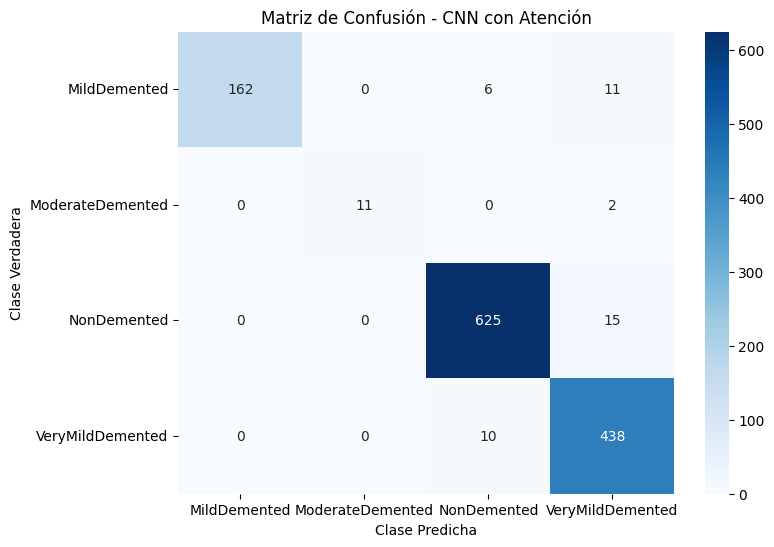


Reporte de Clasificación:
                  precision    recall  f1-score   support

    MildDemented       1.00      0.91      0.95       179
ModerateDemented       1.00      0.85      0.92        13
     NonDemented       0.98      0.98      0.98       640
VeryMildDemented       0.94      0.98      0.96       448

        accuracy                           0.97      1280
       macro avg       0.98      0.93      0.95      1280
    weighted avg       0.97      0.97      0.97      1280



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 5. Evaluar el modelo en el conjunto de prueba
print("Evaluando el modelo CNN con atención en el conjunto de prueba...")
loss_cnn_attention, accuracy_cnn_attention = model_cnn_attention.evaluate(X_test, y_test, verbose=0)

print(f"Pérdida en el conjunto de prueba: {loss_cnn_attention:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy_cnn_attention:.4f}")

# 6. Calcular predicciones en el conjunto de prueba
print("Calculando predicciones en el conjunto de prueba...")
y_pred_prob_cnn_attention = model_cnn_attention.predict(X_test)
y_pred_classes_cnn_attention = np.argmax(y_pred_prob_cnn_attention, axis=1)

# 7. Calcular y mostrar la matriz de confusión y el reporte de clasificación
print("Calculando y mostrando la matriz de confusión y el reporte de clasificación...")
conf_matrix_cnn_attention = confusion_matrix(y_test, y_pred_classes_cnn_attention)
class_report_cnn_attention = classification_report(y_test, y_pred_classes_cnn_attention, target_names=label_encoder.classes_)

print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn_attention, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - CNN con Atención')
plt.show()

print("\nReporte de Clasificación:")
print(class_report_cnn_attention)

**Reasoning**:
Plot the training and validation loss and accuracy curves from the training history as requested in the instructions.



Graficando curvas de pérdida y precisión...


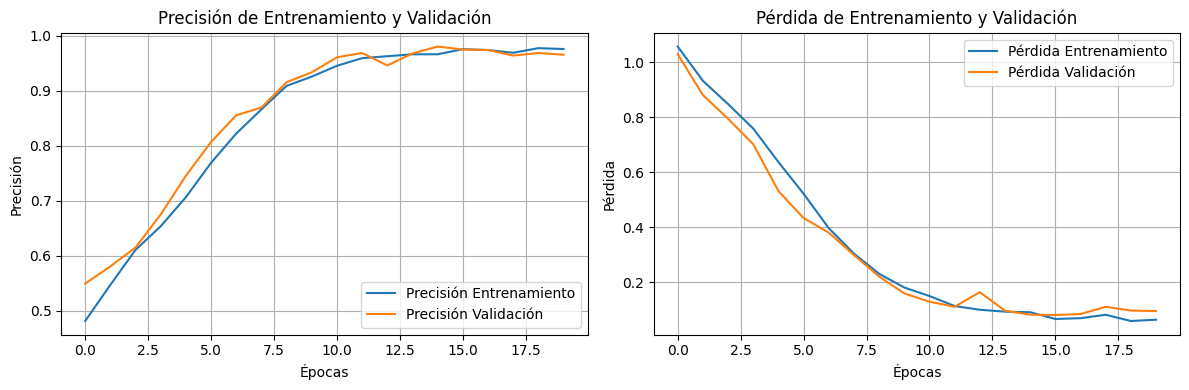

Gráficos generados.


In [ ]:
# 8. Graficar las curvas de pérdida y precisión
print("Graficando curvas de pérdida y precisión...")

history_dict_cnn_attention = history_cnn_attention.history

acc = history_dict_cnn_attention['accuracy']
val_acc = history_dict_cnn_attention['val_accuracy']
loss = history_dict_cnn_attention['loss']
val_loss = history_dict_cnn_attention['val_loss']

epochs_range = range(epochs) # Usar el número de épocas definido anteriormente

plt.figure(figsize=(12, 4))

# Gráfico de Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True)

# Gráfico de Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Gráficos generados.")

 Modelo 2: Cnn con mecanismo de atención


Generando y visualizando mapas de calor Grad-CAM para 5 imágenes de prueba...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/tmp/ipython-input-2848726403.py:123: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = np.uint8(255 * heatmap_resized)
/tmp/ipython-input-2848726403.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
/tmp/ipython-input-2848726403.py:123: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = np.uint8(255 * heatmap_resized)
/tmp/ipython-input-2848726403.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")
/tmp/ipython-input-2848726403.py:123: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = np.uint8(255 * heatmap_resized

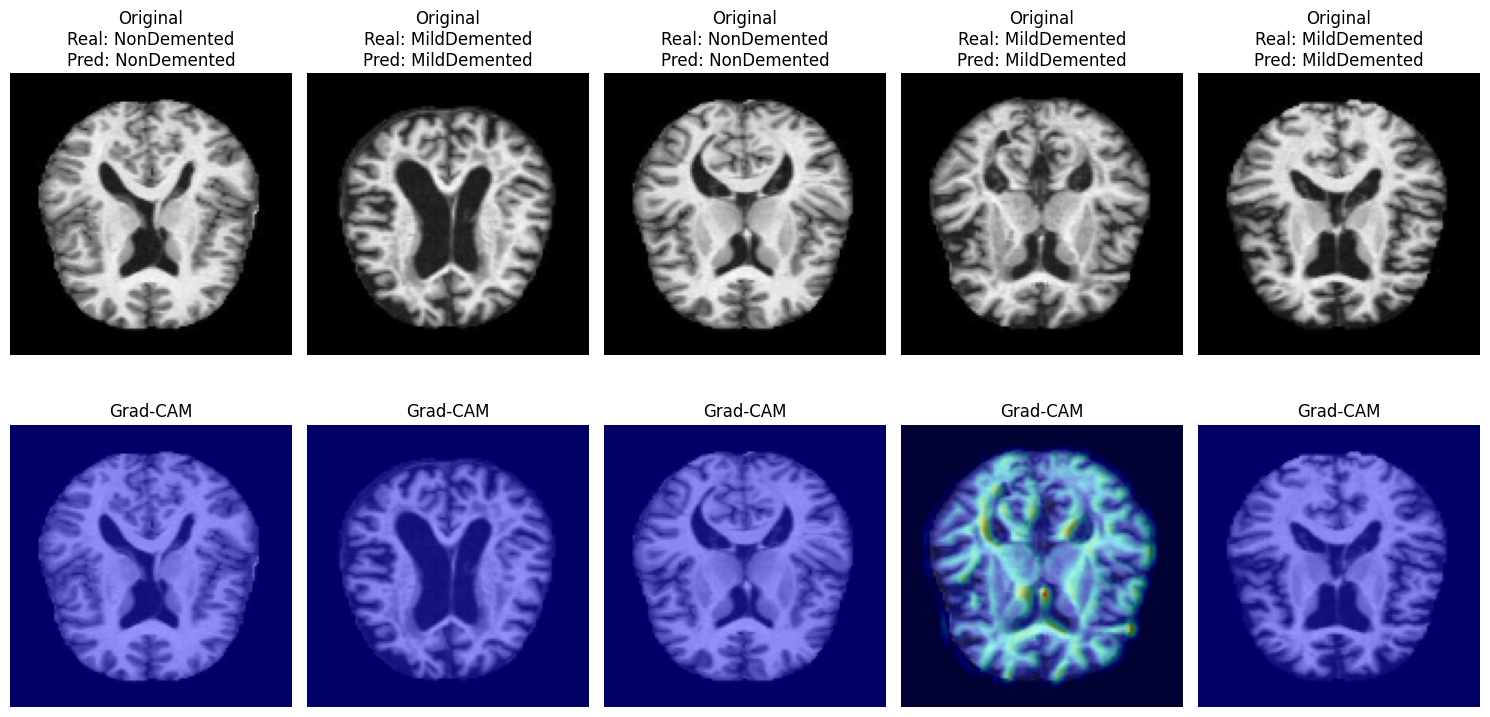

Visualización de Grad-CAM finalizada.

Guardando el modelo CNN con atención...
Modelo CNN con atención guardado como 'cnn_attention_alzheimer_classifier.h5'


In [ ]:
# 9. Implementar Grad-CAM para interpretabilidad y visualizar resultados

# Función para obtener el mapa de calor Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Asegurarse de que la imagen sea float32 para el cálculo de gradientes
    img_array = tf.cast(img_array, tf.float32)

    # Crear un modelo que mapea la imagen de entrada a los activaciones de la última capa convolucional
    # y a las predicciones de la capa de salida
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Usar tf.GradientTape para registrar las operaciones para la diferenciación automática
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(tf.expand_dims(img_array, 0))
        if pred_index is None:
            # Predecir la clase con mayor probabilidad si no se especifica un índice
            pred_index = tf.argmax(predictions[0])
        # Obtener la puntuación de la clase predicha
        class_channel = predictions[:, pred_index]

    # Calcular los gradientes de la puntuación de la clase predicha con respecto a los mapas de características
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Promediar los gradientes a lo largo de cada canal de los mapas de características
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Ponderar cada canal de los mapas de características por el promedio de gradientes
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizar el mapa de calor entre 0 y 1 para visualización
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

# Función para superponer el mapa de calor en la imagen original
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Cargar la imagen original
    img = cv.imread(img_path)
    img = cv.resize(img, img_size) # Asegurarse de que tenga el mismo tamaño que la entrada del modelo
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convertir BGR a RGB

    # Redimensionar el mapa de calor al tamaño de la imagen original
    heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convertir el mapa de calor a RGB
    heatmap = np.uint8(255 * heatmap)

    # Aplicar un mapa de color al mapa de calor
    jet = plt.cm.get_cmap("jet") # Usar el mapa de color 'jet'

    # Obtener los colores jet en formato RGB
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Crear una imagen con el mapa de calor coloreado
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superponer el mapa de calor en la imagen original
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


# Nombre de la última capa convolucional para Grad-CAM
# Puedes obtener el nombre de la capa del resumen del modelo.
# En este caso, la última capa Conv2D antes de Flatten es 'conv2d_5' según el traceback.
last_conv_layer_name = 'conv2d_5' # Corregido el nombre de la capa

# Seleccionar algunas imágenes del conjunto de prueba para visualizar Grad-CAM
num_images_to_show_gradcam = 5
random_indices_gradcam = random.sample(range(len(X_test)), num_images_to_show_gradcam)

plt.figure(figsize=(15, 8))

print(f"\nGenerando y visualizando mapas de calor Grad-CAM para {num_images_to_show_gradcam} imágenes de prueba...")

# Obtener las rutas de archivo para las imágenes de prueba seleccionadas
# Esto requiere reconstruir las rutas basándose en los datos originales
# (Nota: Esto asume que el orden de las imágenes cargadas originalmente coincide con X_test)
# Una forma más robusta sería guardar las rutas de archivo originales junto con los datos.
# Para simplificar, vamos a usar las imágenes del array X_test y
# mostraremos la imagen preprocesada con el mapa de calor superpuesto.

# También necesitamos la clase predicha para cada imagen seleccionada
y_pred_prob_cnn_attention_sample = model_cnn_attention.predict(X_test[random_indices_gradcam])
y_pred_classes_cnn_attention_sample = np.argmax(y_pred_prob_cnn_attention_sample, axis=1)


for i, idx in enumerate(random_indices_gradcam):
    img_array = X_test[idx]
    true_label_encoded = y_test[idx]
    predicted_label_encoded = y_pred_classes_cnn_attention_sample[i]

    true_label = label_encoder.inverse_transform([true_label_encoded])[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

    # Generar el mapa de calor Grad-CAM para la clase predicha
    heatmap = make_gradcam_heatmap(img_array, model_cnn_attention, last_conv_layer_name, pred_index=predicted_label_encoded)

    # Convertir el heatmap a float32 before resizing
    heatmap = heatmap.astype(np.float32)

    # Convertir la imagen preprocesada (float [0,1]) de nuevo a uint8 [0, 255] para superposición
    img_display = (img_array * 255).astype(np.uint8)

    # Superponer el mapa de calor en la imagen original
    # La función save_and_display_gradcam fue diseñada para rutas de archivo,
    # la adaptaremos para trabajar con el array de imagen.
    # Convertir el array de imagen a PIL Image para usar la función de superposición
    img_pil = tf.keras.preprocessing.image.array_to_img(img_display)

    # Redimensionar el mapa de calor al tamaño de la imagen original
    heatmap_resized = cv.resize(heatmap, (img_pil.width, img_pil.height))

    # Convertir el mapa de calor a RGB y aplicar mapa de color
    heatmap_colored = np.uint8(255 * heatmap_resized)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_colored]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_pil.width, img_pil.height))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superponer el mapa de calor en la imagen original
    superimposed_img_array = jet_heatmap * 0.4 + tf.keras.preprocessing.image.img_to_array(img_pil) * (1 - 0.4)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img_array)


    plt.subplot(2, num_images_to_show_gradcam, i + 1)
    plt.imshow(img_display) # Mostrar la imagen original (reconvertida a uint8)
    plt.title(f"Original\nReal: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

    plt.subplot(2, num_images_to_show_gradcam, i + num_images_to_show_gradcam + 1)
    plt.imshow(superimposed_img) # Mostrar la imagen con Grad-CAM superpuesto
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Visualización de Grad-CAM finalizada.")


# 10. Guardar el modelo entrenado
print("\nGuardando el modelo CNN con atención...")
model_cnn_attention.save('cnn_attention_alzheimer_classifier.h5')
print("Modelo CNN con atención guardado como 'cnn_attention_alzheimer_classifier.h5'")

## Modelo 3: 3d-cnn + svm



In [ ]:
# Sección 3: Modelo 3D-CNN + SVM

# 1. Explicación del modelo 3D-CNN + SVM
"""
Este enfoque combina la capacidad de una Red Neuronal Convolucional 3D (3D-CNN) para extraer características de datos
volumétricos con la robustez de un clasificador Support Vector Machine (SVM).

Las 3D-CNNs extienden las 2D-CNNs para trabajar directamente con datos tridimensionales, como imágenes médicas volumétricas
(MRI, CT scans) o secuencias de video. Utilizan filtros convolucionales 3D que se deslizan a través de las tres
dimensiones espaciales (ancho, alto, profundidad/tiempo), permitiendo capturar patrones y relaciones en un contexto
volumétrico o temporal. Esto es particularmente útil para datos médicos donde la estructura 3D del cerebro
es crucial para el diagnóstico.

En este modelo combinado:
- La 3D-CNN actúa como un extractor de características. Se entrena (o se utiliza una pre-entrenada) para aprender
  representaciones jerárquicas y de alto nivel de los datos de entrada. Las capas finales de la 3D-CNN (antes de la capa
  de clasificación final) producen un vector de características que encapsula la información relevante de la entrada.
- El clasificador SVM toma este vector de características extraídas por la 3D-CNN como entrada y realiza la clasificación final.
  Los SVMs son modelos de aprendizaje supervisado que buscan el hiperplano óptimo que mejor separe las diferentes clases
  en el espacio de características. Son conocidos por su buen desempeño en espacios de alta dimensión y con conjuntos
  de datos de tamaño moderado.

La combinación aprovecha la capacidad de las 3D-CNNs para aprender características complejas de datos volumétricos y la
eficiencia y generalización de los SVMs para la clasificación.

Aunque nuestro dataset actual consiste en imágenes 2D, para demostrar el concepto de 3D-CNN, simularemos una dimensión
adicional (por ejemplo, una dimensión de canal única o una dimensión de "profundidad" dummy de tamaño 1) para adaptar
los datos de entrada a la forma esperada por las capas 3D. En un escenario real con MRIs 3D, la entrada sería
directamente el volumen.
"""

# 2. Construir una arquitectura simple de 3D-CNN para extracción de características

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input, BatchNormalization, Activation, ZeroPadding3D

# Definir la forma de la entrada para una 3D-CNN
# Asumimos una dimensión de 'profundidad' de 1 para simular datos volumétricos 2D
# La forma será (profundidad, altura, ancho, canales) -> (1, 128, 128, 3)
# O si tratamos los canales como una dimensión espacial: (canales, altura, ancho, 1) -> (3, 128, 128, 1)
# Vamos a usar (altura, ancho, profundidad, canales) que es más común en TF/Keras para 3D
# Simularemos la profundidad con 1: (128, 128, 1, 3)
input_shape_3d = (img_size[0], img_size[1], 1, 3) # (height, width, depth, channels)

inputs_3d = Input(shape=input_shape_3d)

# Bloque Convolucional 3D 1
x = Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same')(inputs_3d)
x = MaxPooling3D(pool_size=(2, 2, 1))(x)
x = BatchNormalization()(x) # Añadir Batch Normalization

# Bloque Convolucional 3D 2
x = Conv3D(64, kernel_size=(3, 3, 1), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2, 2, 1))(x)
x = BatchNormalization()(x) # Añadir Batch Normalization

# Bloque Convolucional 3D 3
x = Conv3D(128, kernel_size=(3, 3, 1), activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2, 2, 1))(x)
x = BatchNormalization()(x) # Añadir Batch Normalization

# La capa Flatten aplanará la salida de la última capa 3D Pooling
x = Flatten()(x)

# Capa densa (esta no será la capa de clasificación final, sino una capa para extraer características)
# El tamaño de esta capa densa determina el tamaño del vector de características
feature_vector_size = 128 # Tamaño del vector de características
feature_output = Dense(feature_vector_size, activation='relu')(x)

# Crear el modelo 3D-CNN para extracción de características
model_3dcnn_feature_extractor = Model(inputs=inputs_3d, outputs=feature_output)

# Mostrar resumen del modelo extractor de características
model_3dcnn_feature_extractor.summary()

print("\nArquitectura simple de 3D-CNN para extracción de características construida.")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 128, 128, 1,    │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 64, 64, 1, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 1, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 64, 64, 1, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 1, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 1, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 32, 32, 1, 128) │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 16, 1, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 1, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,576 (16.36 MB)

 Trainable params: 4,288,128 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)


Arquitectura simple de 3D-CNN para extracción de características construida.


**Reasoning**:
Adaptar los datos de entrada para la 3D-CNN, extraer características usando la 3D-CNN y entrenar un clasificador SVM.



In [ ]:
from sklearn.svm import SVC
import joblib

# 3. Adaptar los datos de entrada para que tengan la forma esperada por una 3D-CNN
# X_train y X_test tienen forma (samples, height, width, channels) -> (N, 128, 128, 3)
# La 3D-CNN espera (samples, height, width, depth, channels) -> (N, 128, 128, 1, 3)
# Añadimos una dimensión en el eje de 'profundidad' con tamaño 1.
X_train_3d = np.expand_dims(X_train, axis=-2) # Añadir dimensión antes del eje de canales
X_test_3d = np.expand_dims(X_test, axis=-2)

print(f"Forma de X_train_3d: {X_train_3d.shape}")
print(f"Forma de X_test_3d: {X_test_3d.shape}")

# 4. Utilizar la 3D-CNN para extraer características
print("\nExtrayendo características con la 3D-CNN...")
X_train_features = model_3dcnn_feature_extractor.predict(X_train_3d)
X_test_features = model_3dcnn_feature_extractor.predict(X_test_3d)

print(f"Forma de las características de entrenamiento: {X_train_features.shape}")
print(f"Forma de las características de prueba: {X_test_features.shape}")

# Las características ya están aplanadas por la capa Flatten y la capa Dense en la 3D-CNN,
# por lo que no es necesario aplanarlas nuevamente para la entrada del SVM.

# 5. Importar y entrenar un clasificador SVM
print("\nEntrenando el clasificador SVM...")
# Usaremos un kernel RBF, que es común para SVMs
svm_classifier = SVC(kernel='rbf', random_state=42)

# Entrenar el SVM con las características extraídas y las etiquetas de entrenamiento
svm_classifier.fit(X_train_features, y_train)

print("Clasificador SVM entrenado exitosamente.")

# 7. Guardar el modelo SVM entrenado
print("\nGuardando el clasificador SVM...")
joblib.dump(svm_classifier, 'svm_alzheimer_classifier.pkl')
print("Clasificador SVM guardado como 'svm_alzheimer_classifier.pkl'")


Forma de X_train_3d: (5120, 128, 128, 1, 3)
Forma de X_test_3d: (1280, 128, 128, 1, 3)

Extrayendo características con la 3D-CNN...
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Forma de las características de entrenamiento: (5120, 128)
Forma de las características de prueba: (1280, 128)

Entrenando el clasificador SVM...
Clasificador SVM entrenado exitosamente.

Guardando el clasificador SVM...
Clasificador SVM guardado como 'svm_alzheimer_classifier.pkl'



Evaluando el clasificador SVM en el conjunto de prueba...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precisión del SVM en el conjunto de prueba: 0.5641

Visualizando la matriz de confusión del clasificador SVM...


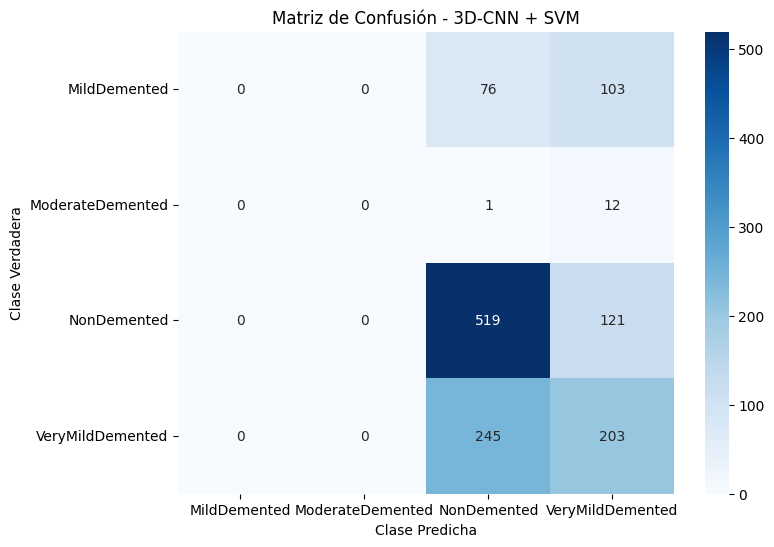


Reporte de Clasificación del SVM:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        13
     NonDemented       0.62      0.81      0.70       640
VeryMildDemented       0.46      0.45      0.46       448

        accuracy                           0.56      1280
       macro avg       0.27      0.32      0.29      1280
    weighted avg       0.47      0.56      0.51      1280



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 6. Evaluar el rendimiento del clasificador SVM entrenado
print("\nEvaluando el clasificador SVM en el conjunto de prueba...")

# Predecir las etiquetas en el conjunto de prueba utilizando las características extraídas
y_pred_svm = svm_classifier.predict(X_test_features)

# Calcular métricas de evaluación
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_)

print(f"Precisión del SVM en el conjunto de prueba: {accuracy_svm:.4f}")

# 8. Visualizar la matriz de confusión del clasificador SVM
print("\nVisualizando la matriz de confusión del clasificador SVM...")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - 3D-CNN + SVM')
plt.show()

print("\nReporte de Clasificación del SVM:")
print(class_report_svm)


## Modelo híbrido (ideeplabv3+ + lenet-5 + eresnext)


In [ ]:
# Sección 4: Modelo Híbrido (IDeepLabV3+ + LeNet-5 + EResNext)

# 1. Explicación del Modelo Híbrido
"""
Este modelo híbrido propone combinar elementos de arquitecturas de redes neuronales reconocidas por sus capacidades
en diferentes aspectos del análisis de imágenes para abordar la clasificación de Alzheimer. La idea es aprovechar
las fortalezas de cada componente:

- IDeepLabV3+: Originalmente diseñado para segmentación semántica, IDeepLabV3+ es eficaz en la captura de
  contexto multi-escala utilizando Atrous Convolution con Atrous Spatial Pyramid Pooling (ASPP) y la integración
  de características de bajo nivel con características de alto nivel mediante un decodificador. Aunque la segmentación
  directa de lesiones de Alzheimer en imágenes 2D puede ser compleja sin datos de segmentación específicos,
  podemos adaptar ideas de IDeepLabV3+ para la extracción de características ricas en contexto multi-escala. Esto
  podría implicar el uso de convoluciones atrous con diferentes tasas para capturar información en múltiples escalas
  dentro de las imágenes cerebrales.

- LeNet-5: Una arquitectura CNN temprana pero fundamental, LeNet-5 es conocida por su eficiencia en la extracción
  de características locales mediante capas convolucionales seguidas de capas de pooling. Integrar un componente
  inspirado en LeNet-5 permitiría al modelo capturar detalles finos y patrones locales en las imágenes, que podrían
  ser relevantes para identificar marcadores tempranos o sutiles de la enfermedad.

- EResNext: Una variante eficiente de ResNeXt, que a su vez se basa en la arquitectura ResNet pero utiliza
  "cardinalidad" (grupos de convoluciones) para mejorar el rendimiento y la eficiencia. Las arquitecturas residuales
  son excelentes para entrenar redes profundas al mitigar el problema del gradiente evanescente. EResNext, con su
  estructura agrupada y conexiones residuales, puede extraer características de alto nivel más complejas y robustas
  de las imágenes.

La integración de estos componentes podría realizarse de varias maneras:
- Una arquitectura en paralelo donde cada componente procesa la imagen de entrada o características intermedias
  y sus salidas se concatenan o combinan de alguna forma antes de la capa de clasificación final.
- Una arquitectura secuencial donde la salida de un componente sirve como entrada para el siguiente, por ejemplo,
  usar un componente inspirado en IDeepLabV3+ para extraer características multi-escala, luego pasarlas a un
  componente tipo LeNet-5 para refinar características locales, y finalmente usar un componente tipo EResNext
  para la extracción de características de alto nivel antes de la clasificación.

Para este ejemplo, construiremos una arquitectura que combine ideas clave de cada uno de forma simplificada,
adaptada a nuestro dataset 2D y centrada en la clasificación. No implementaremos la segmentación explícita,
sino que usaremos los principios de extracción de características de cada arquitectura.
"""

# 2. Construir la arquitectura del modelo híbrido en Keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation # For EResNext components
from tensorflow.keras import regularizers # For L2 regularization if needed

# Helper function for a basic EResNext block (simplified)
def eresnext_block(inputs, filters, cardinality, stride=1, use_shortcut=True):
    """Simplified EResNext block."""
    channel_axis = -1 # channels_last
    group_filters = filters // cardinality

    x = inputs
    shortcut = inputs

    # Bottleneck convolution 1x1
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    # Grouped Convolution
    # Simulate grouped conv by using Conv2D with 'groups' argument if available and compatible
    # or by splitting and concatenating if not. The 'groups' argument is preferred.
    # Note: The 'groups' argument in Conv2D is available in TensorFlow 2.x
    if filters % cardinality == 0:
        x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False, groups=cardinality)(x)
    else:
        # Fallback or simplified approach if groups argument is not suitable
        x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    # Bottleneck convolution 1x1
    x = Conv2D(filters * 2, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)

    # Add shortcut
    if use_shortcut:
        # 1x1 conv shortcut for dimension mismatch
        if stride != 1 or inputs.shape[channel_axis] != filters * 2:
            shortcut = Conv2D(filters * 2, kernel_size=1, strides=stride, padding='same', use_bias=False)(inputs)
            shortcut = BatchNormalization(axis=channel_axis)(shortcut)
        x = Add()([x, shortcut])

    x = Activation('relu')(x)
    return x


# Define the input shape
input_shape = (img_size[0], img_size[1], 3)
inputs = Input(shape=input_shape)

# --- Component inspired by IDeepLabV3+ (Simplified Atrous Convolutions) ---
# Use Conv2D with dilation_rate
x_deeplab = Conv2D(64, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(inputs)
x_deeplab = Conv2D(64, kernel_size=3, dilation_rate=4, padding='same', activation='relu')(x_deeplab)
x_deeplab = Conv2D(64, kernel_size=3, dilation_rate=8, padding='same', activation='relu')(x_deeplab)
# Combine features (simple concatenation)
# In a real IDeepLabV3+, ASPP and a decoder would be used.
# Here we just capture multi-scale context via dilated convs.


# --- Component inspired by LeNet-5 ---
x_lenet = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
x_lenet = MaxPooling2D((2, 2))(x_lenet)
x_lenet = Conv2D(64, (5, 5), activation='relu', padding='same')(x_lenet)
x_lenet = MaxPooling2D((2, 2))(x_lenet)


# --- Component inspired by EResNext ---
# Start with an initial convolution
x_eresnext = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
x_eresnext = BatchNormalization(axis=-1)(x_eresnext)
x_eresnext = Activation('relu')(x_eresnext)
x_eresnext = MaxPooling2D(pool_size=3, strides=2, padding='same')(x_eresnext)

# Add EResNext blocks
x_eresnext = eresnext_block(x_eresnext, filters=64, cardinality=32)
x_eresnext = eresnext_block(x_eresnext, filters=64, cardinality=32)
x_eresnext = eresnext_block(x_eresnext, filters=128, cardinality=32, stride=2)
x_eresnext = eresnext_block(x_eresnext, filters=128, cardinality=32)


# --- Combine Features from all components ---
# Need to ensure feature map sizes are compatible for concatenation or sum.
# Use GlobalAveragePooling2D or Flatten to get feature vectors.
# A more sophisticated approach would involve carefully designed upsampling/downsampling
# or attention mechanisms to combine feature maps.
# For simplicity, let's flatten and concatenate features after some processing.

# Process IDeepLab+ features
# Need to ensure spatial dimensions match before concatenation if not flattening immediately
# Let's downsample deeplab and lenet features to roughly match eresnext spatial dim before flattening
# eresnext after first maxpooling (stride 2), then eresnext block (stride 2) -> spatial size is roughly input_size / 4
# Let's add pooling to deeplab and lenet branches

x_deeplab_pooled = MaxPooling2D((4, 4))(x_deeplab) # Adjust pool size based on desired output size
x_lenet_pooled = MaxPooling2D((2, 2))(x_lenet) # Adjust pool size

# Now flatten and concatenate
x_deeplab_flatten = Flatten()(x_deeplab_pooled)
x_lenet_flatten = Flatten()(x_lenet_pooled)
x_eresnext_flatten = Flatten()(x_eresnext) # eresnext is already reduced by its blocks

combined_features = concatenate([x_deeplab_flatten, x_lenet_flatten, x_eresnext_flatten])

# Dense layers for classification
x = Dense(256, activation='relu')(combined_features)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax', dtype='float32')(x) # Final output layer

# Create the hybrid model
model_hybrid = Model(inputs=inputs, outputs=outputs)

# Show summary of the hybrid model
model_hybrid.summary()

# 3. Compilar el modelo híbrido
model_hybrid.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

print("\nModelo Híbrido compilado exitosamente.")

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      9,408 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │      4,096 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │      1,152 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │      8,192 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      8,192 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ add[0][0]       

 Total params: 38,092,548 (145.31 MB)

 Trainable params: 38,088,580 (145.30 MB)

 Non-trainable params: 3,968 (15.50 KB)


Modelo Híbrido compilado exitosamente.


Iniciando entrenamiento del modelo híbrido...
Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - accuracy: 0.4597 - loss: 15.0353 - val_accuracy: 0.5000 - val_loss: 1.1702
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4973 - loss: 1.1899 - val_accuracy: 0.5000 - val_loss: 1.0642
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5044 - loss: 1.0972 - val_accuracy: 0.5000 - val_loss: 1.0608
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5010 - loss: 1.0659 - val_accuracy: 0.5000 - val_loss: 0.9111
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.4985 - loss: 1.0367 - val_accuracy: 0.5000 - val_loss: 0.9014
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4935 - loss: 1.0029 - val_accuracy: 0.5000 - val_loss: 0.9790
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5053 - loss: 0.9904 - val_accuracy: 0.5000 - val_loss: 1.1229
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


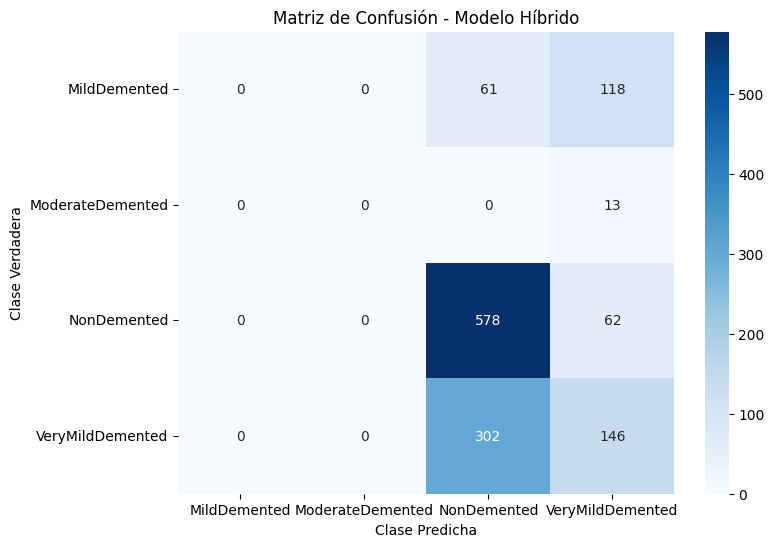


Reporte de Clasificación:
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        13
     NonDemented       0.61      0.90      0.73       640
VeryMildDemented       0.43      0.33      0.37       448

        accuracy                           0.57      1280
       macro avg       0.26      0.31      0.28      1280
    weighted avg       0.46      0.57      0.50      1280



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 4. Entrenar el modelo híbrido
print("Iniciando entrenamiento del modelo híbrido...")

# Definir parámetros de entrenamiento (reutilizamos los definidos anteriormente)
# epochs = 20
# batch_size = 32

history_hybrid = model_hybrid.fit(X_train, y_train,
                                  epochs=epochs, # Usar el número de épocas definido globalmente
                                  batch_size=batch_size, # Usar el tamaño del batch definido globalmente
                                  validation_data=(X_test, y_test), # Usar el conjunto de prueba como validación
                                  verbose=1) # Mostrar el progreso del entrenamiento

print("Entrenamiento del modelo híbrido finalizado.")

# 5. Evaluar el modelo en el conjunto de prueba
print("\nEvaluando el modelo híbrido en el conjunto de prueba...")
loss_hybrid, accuracy_hybrid = model_hybrid.evaluate(X_test, y_test, verbose=0)

print(f"Pérdida en el conjunto de prueba: {loss_hybrid:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy_hybrid:.4f}")

# 6. Calcular predicciones en el conjunto de prueba
print("\nCalculando predicciones en el conjunto de prueba...")
y_pred_prob_hybrid = model_hybrid.predict(X_test)
y_pred_classes_hybrid = np.argmax(y_pred_prob_hybrid, axis=1)

# 7. Calcular y mostrar la matriz de confusión y el reporte de clasificación
print("\nCalculando y mostrando la matriz de confusión y el reporte de clasificación...")
conf_matrix_hybrid = confusion_matrix(y_test, y_pred_classes_hybrid)
class_report_hybrid = classification_report(y_test, y_pred_classes_hybrid, target_names=label_encoder.classes_)

print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Modelo Híbrido')
plt.show()

print("\nReporte de Clasificación:")
print(class_report_hybrid)

In [ ]:
!git clone https://github.com/ianlw/deep-alzheimer.git

Cloning into 'deep-alzheimer'...
remote: Enumerating objects: 6406, done.
remote: Counting objects: 100% (6406/6406), done.
remote: Compressing objects: 100% (6406/6406), done.
remote: Total 6406 (delta 0), reused 6406 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6406/6406), 32.96 MiB | 23.05 MiB/s, done.


In [ ]:
# Forzar uso de memoria eficiente
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verificar política activa
print("Política de precisión:", mixed_precision.global_policy())


Política de precisión: <DTypePolicy "mixed_float16">


In [ ]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi


Sat Nov  1 10:43:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
from os.path import join
from glob import glob
import numpy as np
import pandas as pd
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets # No necesitarás esto en Colab si subes los datos
import matplotlib.pyplot as plt
import PIL
import random

from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2 as cv # Asegúrate de que OpenCV esté instalado (pip install opencv-python)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, \
    confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Configuración de TPU/GPU en Colab (generalmente se detecta automáticamente)
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy() # Esto debería funcionar en Colab
# print('Number of replicas:', strategy.num_replicas_in_sync)

# Usa la estrategia por defecto en Colab si no configuras TPU específicamente
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


print(tf.__version__)

Number of replicas: 1
2.19.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync #tamaño de lote
IMAGE_SIZE = [176, 208] #tamaño de la imagen
EPOCHS = 40 # número máximo de épocas.

In [ ]:
data_folder = "./deep-alzheimer"

## Imágenes NonDemented
df_NonDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "NonDemented", "*"))),
    "y": 0,
    "class": "NonDementia"
})
shuffled_non = df_NonDemented_imgs.sample(frac=1)
testsize_non = int(0.2 * len(shuffled_non))
# Prueba
non_test = shuffled_non[:testsize_non]
# Entrenamiento y validación
non_trainval = shuffled_non[testsize_non:]
trainsize_non = int(0.8 * len(non_trainval))
# Entrenamiento
shuffled_non_train = non_trainval[:trainsize_non]
# Validación
shuffled_non_val = non_trainval[trainsize_non:]


## Imágenes VeryMildDemented
df_VeryMildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "VeryMildDemented", "*"))),
    "y": 1,
    "class": "VeryMildDementia"
})
shuffled_verymild = df_VeryMildDemented_imgs.sample(frac=1)
testsize_verymild = int(0.2 * len(shuffled_verymild))

verymild_test = shuffled_verymild[:testsize_verymild]

verymild_trainval = shuffled_verymild[testsize_verymild:]
trainsize_verymild = int(0.8 * len(verymild_trainval))

shuffled_verymild_train = verymild_trainval[:trainsize_verymild]

shuffled_verymild_val = verymild_trainval[trainsize_verymild:]


## Imágenes MildDemented
df_MildDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "MildDemented", "*"))),
    "y": 2,
    "class": "MildDementia"
})
shuffled_mild = df_MildDemented_imgs.sample(frac=1)
testsize_mild = int(0.2 * len(shuffled_mild))

mild_test = shuffled_mild[:testsize_mild]

mild_trainval = shuffled_mild[testsize_mild:]
trainsize_mild = int(0.8 * len(mild_trainval))

shuffled_mild_train = mild_trainval[:trainsize_mild]

shuffled_mild_val = mild_trainval[trainsize_mild:]

## Imágenes ModerateDemented
df_ModerateDemented_imgs = pd.DataFrame({
    "X": sorted(glob(join(data_folder, "ModerateDemented", "*"))),
    "y": 3,
    "class": "ModerateDementia"
})
shuffled_moderate = df_ModerateDemented_imgs.sample(frac=1)
testsize_moderate = int(0.2 * len(shuffled_moderate))

moderate_test = shuffled_moderate[:testsize_moderate]

moderate_trainval = shuffled_moderate[testsize_moderate:]
trainsize_moderate = int(0.8 * len(moderate_trainval))

shuffled_moderate_train = moderate_trainval[:trainsize_moderate]

shuffled_moderate_val = moderate_trainval[trainsize_moderate:]


# Número de imágenes para imprimir

print("TOTAL:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate))
print("------------")
print("\nTest:")
print("# of images with NonDemented Alzheimer =", len(non_test))
print("# of images with VeryMildDemented Alzheimer =", len(verymild_test))
print("# of images with MildDemented Alzheimer =", len(mild_test))
print("# of images with ModerateDemented Alzheimer =", len(moderate_test))
print("------------")
print("\nTraining:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non_train))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild_train))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild_train))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate_train))
print("------------")
print("\nValidation:")
print("# of images with NonDemented Alzheimer =", len(shuffled_non_val))
print("# of images with VeryMildDemented Alzheimer =", len(shuffled_verymild_val))
print("# of images with MildDemented Alzheimer =", len(shuffled_mild_val))
print("# of images with ModerateDemented Alzheimer =", len(shuffled_moderate_val))

TOTAL:
# of images with NonDemented Alzheimer = 3200
# of images with VeryMildDemented Alzheimer = 2240
# of images with MildDemented Alzheimer = 896
# of images with ModerateDemented Alzheimer = 64
------------

Test:
# of images with NonDemented Alzheimer = 640
# of images with VeryMildDemented Alzheimer = 448
# of images with MildDemented Alzheimer = 179
# of images with ModerateDemented Alzheimer = 12
------------

Training:
# of images with NonDemented Alzheimer = 2048
# of images with VeryMildDemented Alzheimer = 1433
# of images with MildDemented Alzheimer = 573
# of images with ModerateDemented Alzheimer = 41
------------

Validation:
# of images with NonDemented Alzheimer = 512
# of images with VeryMildDemented Alzheimer = 359
# of images with MildDemented Alzheimer = 144
# of images with ModerateDemented Alzheimer = 11


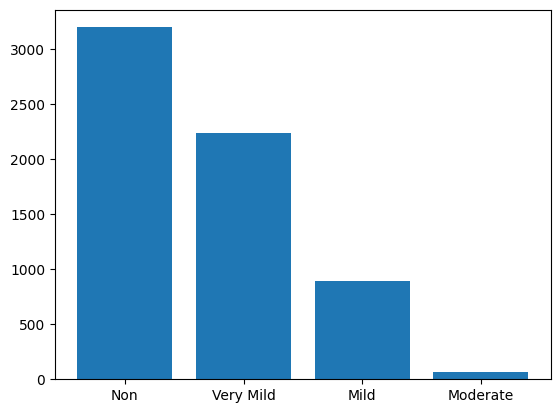

In [ ]:
# mostrando el desequilibrio en el dataset

heights = [len(shuffled_non), len(shuffled_verymild), len(shuffled_mild), len(shuffled_moderate)]

fig, ax = plt.subplots()
height = heights
bars = ('Non', 'Very Mild', 'Mild', 'Moderate')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7689 - loss: 1.0843
LSTM Model Evaluation (loss, auc): [1.0944721698760986, 0.7618020176887512]
LSTM Model Metrics:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy     = 0.4409695074276779
Bal Accuracy = 0.29303723147778665
Precision    = 0.33341665432281636
Recall       = 0.29303723147778665
f1           = 0.2999590137585187
AUC          = nan




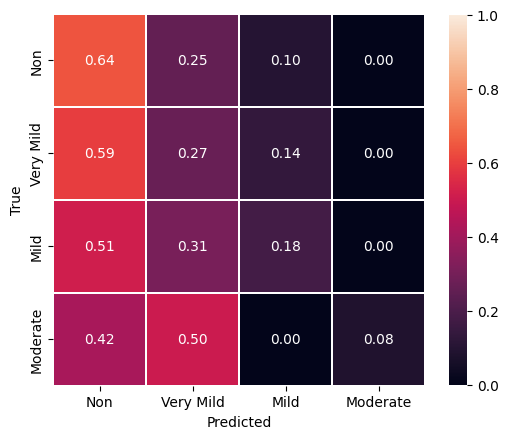

In [ ]:
# Evaluate the LSTM model
lstm_evaluation = lstm_model.evaluate(xtest_reshaped, ytest)
print("LSTM Model Evaluation (loss, auc):", lstm_evaluation)

# Print metrics for the LSTM model
y_test_lstm = ytest.argmax(axis=1)
print("LSTM Model Metrics:")
lstm_metrics = print_metrics(lstm_model, xtest_reshaped, y_test_lstm)

In [ ]:
def load_image(fname):

    # img es una matriz numpy
    img = cv.imread(fname)
    # opencv usa canal BGR
    # so convierte a RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Cambiando tamaño de imagen
    resize = (IMAGE_SIZE[0], IMAGE_SIZE[1])
    img = cv.resize(img, resize)
    return img

def hot_array(class_number):
    ha = [0,0,0,0]
    ha[class_number] = 1
    return ha

In [ ]:
## Entrenando
# Concatenamos
train_concat = pd.concat([shuffled_mild_train, shuffled_moderate_train, shuffled_non_train, shuffled_verymild_train])
# mezcla
train_concat = train_concat.sample(frac=1)
# cargar imagen
train_concat["X"] = train_concat["X"].apply(load_image)

y_train_lab = train_concat["y"]
y_train_lab = np.array(y_train_lab) # convierte en numpy array

# codificación one hot
train_concat["y"] = train_concat["y"].apply(hot_array)

xtrain = np.stack(train_concat["X"])
ytrain = np.stack(train_concat["y"])


## Conjunto de validación
val_concat = pd.concat([shuffled_mild_val, shuffled_moderate_val, shuffled_non_val, shuffled_verymild_val])
val_concat = val_concat.sample(frac=1)
val_concat["X"] = val_concat["X"].apply(load_image)
val_concat["y"] = val_concat["y"].apply(hot_array)
xval = np.stack(val_concat["X"])
yval = np.stack(val_concat["y"])

Text(0, 0.5, 'Moderate Dementia')

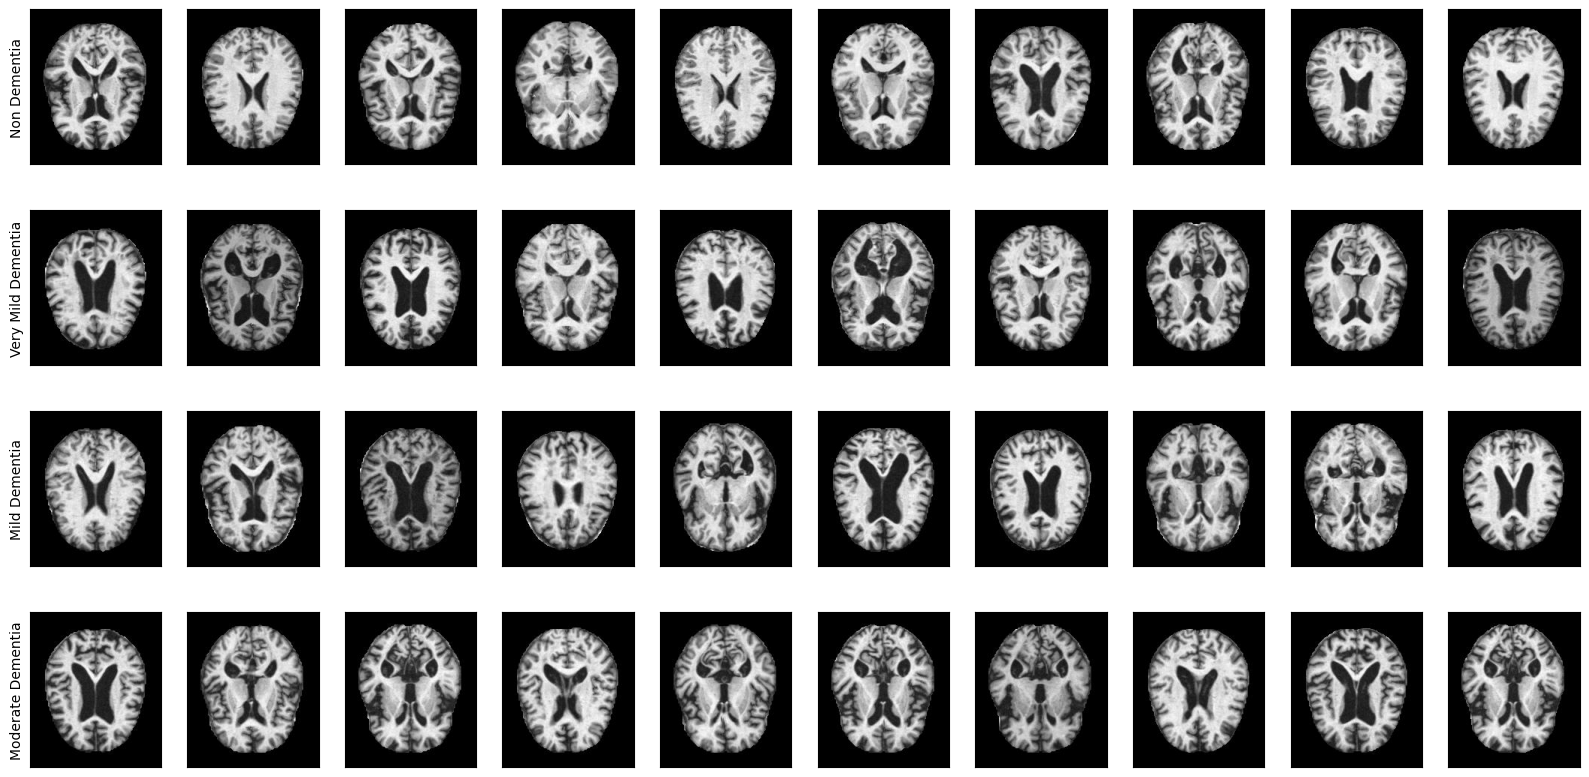

In [ ]:
# Mostrando algunas imágenes

ncols = 10

fig, axs = plt.subplots(nrows=4, ncols=ncols, figsize=(20, 10))

for fname,ax in zip(shuffled_non.loc[:ncols, "X"], axs[0,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_verymild.loc[:ncols, "X"], axs[1,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_mild.loc[:ncols, "X"], axs[2,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for fname,ax in zip(shuffled_moderate.loc[:ncols, "X"], axs[3,:]):
    im = load_image(fname)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

axs[0,0].set_ylabel("Non Dementia")
axs[1,0].set_ylabel("Very Mild Dementia")
axs[2,0].set_ylabel("Mild Dementia")
axs[3,0].set_ylabel("Moderate Dementia")

In [ ]:
# Bloque convolucional
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

# Bloque denso
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

# Función para construir el modelo.
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        # Escogiendo el optimizador ADAM con learning rate de 0.001
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),

        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.5, verbose=1, mode="auto",
                              cooldown=5, patience=10, min_lr=0.00001)

# Agregando pesos de clase para compensar el desequilibrio
class_weights = { 0: 1,
                  1: 1.5,
                  2: 3,
                  3: 20
}

# Entrenando el modelo
history = model.fit(xtrain, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr], validation_data=(xval, yval), class_weight = class_weights)

Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - auc: 0.5749 - loss: 3.0544

128/128 ━━━━━━━━━━━━━━━━━━━━ 167s 697ms/step - auc: 0.5752 - loss: 3.0519 - val_auc: 0.7294 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 2/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.6842 - loss: 2.2849

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.6845 - loss: 2.2838 - val_auc: 0.7508 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.7425 - loss: 1.9971 - val_auc: 0.7726 - val_loss: 1.5823 - learning_rate: 0.0010
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.7763 - loss: 1.7603 - val_auc: 0.7755 - val_loss: 1.7379 - learning_rate: 0.0010
Epoch 5/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.8250 - loss: 1.4626

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.8250 - loss: 1.4633 - val_auc: 0.8386 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.8502 - loss: 1.3531 - val_auc: 0.8214 - val_loss: 1.2415 - learning_rate: 0.0010
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8837 - loss: 1.1710 - val_auc: 0.7719 - val_loss: 1.9181 - learning_rate: 0.0010
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.8944 - loss: 1.1069 - val_auc: 0.8365 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 9/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9314 - loss: 0.8811

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9315 - loss: 0.8804 - val_auc: 0.9523 - val_loss: 0.5191 - learning_rate: 0.0010
Epoch 10/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9510 - loss: 0.7702 - val_auc: 0.7177 - val_loss: 3.7618 - learning_rate: 0.0010
Epoch 11/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.9608 - loss: 0.6199
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9609 - loss: 0.6195 - val_auc: 0.7992 - val_loss: 1.9311 - learning_rate: 0.0010
Epoch 12/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9729 - loss: 0.5294

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9730 - loss: 0.5285 - val_auc: 0.9866 - val_loss: 0.2620 - learning_rate: 5.0000e-04
Epoch 13/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9860 - loss: 0.3753 - val_auc: 0.9801 - val_loss: 0.3399 - learning_rate: 5.0000e-04
Epoch 14/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9878 - loss: 0.3448 - val_auc: 0.8862 - val_loss: 1.3310 - learning_rate: 5.0000e-04
Epoch 15/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9911 - loss: 0.2943 - val_auc: 0.9614 - val_loss: 0.4763 - learning_rate: 5.0000e-04
Epoch 16/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9914 - loss: 0.3036 - val_auc: 0.9401 - val_loss: 0.7508 - learning_rate: 5.0000e-04
Epoch 17/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9944 - loss: 0.2235 - val_auc: 0.9036 - val_loss: 1.1496 - learning_rate: 5.0000e-04
Epoch 18/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.9957 - loss: 0.2105

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - auc: 0.9957 - loss: 0.2105 - val_auc: 0.9896 - val_loss: 0.2266 - learning_rate: 5.0000e-04
Epoch 19/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9967 - loss: 0.1807

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - auc: 0.9967 - loss: 0.1808 - val_auc: 0.9917 - val_loss: 0.1912 - learning_rate: 5.0000e-04
Epoch 20/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9964 - loss: 0.1792 - val_auc: 0.9812 - val_loss: 0.3427 - learning_rate: 5.0000e-04
Epoch 21/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9944 - loss: 0.2405 - val_auc: 0.9894 - val_loss: 0.2071 - learning_rate: 5.0000e-04
Epoch 22/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9959 - loss: 0.1792 - val_auc: 0.9881 - val_loss: 0.2200 - learning_rate: 5.0000e-04
Epoch 23/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9969 - loss: 0.1743 - val_auc: 0.9486 - val_loss: 0.6487 - learning_rate: 5.0000e-04
Epoch 24/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9973 - loss: 0.1560 - val_auc: 0.9880 - val_loss: 0.2295 - learning_rate: 5.0000e-04
Epoch 25/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9978 - loss: 0.1354
Epoch 25: ReduceLROnPlateau reducing lear

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9962 - loss: 0.2170 - val_auc: 0.9937 - val_loss: 0.1701 - learning_rate: 2.5000e-04
Epoch 27/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9985 - loss: 0.1100

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9985 - loss: 0.1098 - val_auc: 0.9934 - val_loss: 0.1441 - learning_rate: 2.5000e-04
Epoch 28/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9994 - loss: 0.0728 - val_auc: 0.9928 - val_loss: 0.2056 - learning_rate: 2.5000e-04
Epoch 29/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9989 - loss: 0.0815 - val_auc: 0.9880 - val_loss: 0.2118 - learning_rate: 2.5000e-04
Epoch 30/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9990 - loss: 0.0867 - val_auc: 0.9805 - val_loss: 0.3534 - learning_rate: 2.5000e-04
Epoch 31/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9995 - loss: 0.0783 - val_auc: 0.9490 - val_loss: 0.6993 - learning_rate: 2.5000e-04
Epoch 32/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9985 - loss: 0.1122 - val_auc: 0.9842 - val_loss: 0.3046 - learning_rate: 2.5000e-04
Epoch 33/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9989 - loss: 0.0817

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9989 - loss: 0.0817 - val_auc: 0.9942 - val_loss: 0.1317 - learning_rate: 2.5000e-04
Epoch 34/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9992 - loss: 0.0728 - val_auc: 0.9899 - val_loss: 0.2437 - learning_rate: 2.5000e-04
Epoch 35/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9995 - loss: 0.0628 - val_auc: 0.9947 - val_loss: 0.1398 - learning_rate: 2.5000e-04
Epoch 36/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9993 - loss: 0.0776 - val_auc: 0.9921 - val_loss: 0.1900 - learning_rate: 2.5000e-04
Epoch 37/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9996 - loss: 0.0662 - val_auc: 0.9933 - val_loss: 0.1703 - learning_rate: 2.5000e-04
Epoch 38/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9985 - loss: 0.0966

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - auc: 0.9985 - loss: 0.0966 - val_auc: 0.9948 - val_loss: 0.1080 - learning_rate: 2.5000e-04
Epoch 39/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.9989 - loss: 0.0681
Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9990 - loss: 0.0681 - val_auc: 0.9677 - val_loss: 0.5292 - learning_rate: 2.5000e-04
Epoch 40/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - auc: 0.9982 - loss: 0.0871

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - auc: 0.9982 - loss: 0.0871 - val_auc: 0.9938 - val_loss: 0.1079 - learning_rate: 1.2500e-04
